### Question 1 ( 10pts+5pts+10pts+5pts+10pts)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

1) We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

2) Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

3) When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following outputs:

1) The kernel after parameter optimization and fitting to the observed data.

2) The log marginal likelihood of the training data.  

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values).

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location?

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
%matplotlib inline

In [2]:
Data1=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


#### Data preprocessing 
Take the logarithm of the traffic counts, and then subtract the mean of this vector to get the final *Average Daily Traffic Counts* 

In [3]:
Data1['ADTC'] = (np.log(Data1.AvgDailyTrafficCount)- \
                 (np.log(Data1.AvgDailyTrafficCount).mean()))
Data1.columns

Index([u'Longitude', u'Latitude', u'AvgDailyTrafficCount', u'ADTC'], dtype='object')

In [4]:
X = Data1.iloc[:,:2]
y = Data1.iloc[:,3]

(array([   9.,    9.,   16.,   31.,   42.,   65.,  121.,  212.,  301.,  309.]),
 array([-3.97752579, -3.45975624, -2.94198669, -2.42421714, -1.90644759,
        -1.38867805, -0.8709085 , -0.35313895,  0.1646306 ,  0.68240015,
         1.2001697 ]),
 <a list of 10 Patch objects>)

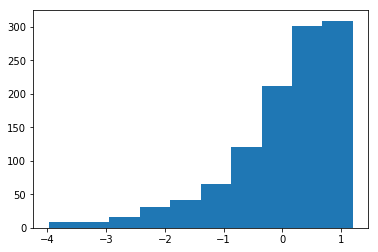

In [5]:
plt.hist(y,bins=10)

## Figure 1 : Histogram of the log of AveDailyTrafficCount
The above plot shows a skewed data towards the right indicating a noisy dataset.

Add a noise kernel to adjust for the noise in the data.

In [6]:
kernel = 1* RBF(length_scale=[0.1], length_scale_bounds=(0.00001, 10000)) \
        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
    
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=10,random_state=999)

In [7]:
gp.fit(X, y)

y_pred, sigma = gp.predict(X, return_std=True)

In [8]:
print("\nLearnt kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


Learnt kernel: 0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)
Log-marginal-likelihood: -1365.028


The log-marginal-likelihood is the theta value of the training data.

### 3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values).

In [9]:
h = .01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X.iloc[:, 0].min(), X.iloc[:, 0].max()
y_min, y_max = X.iloc[:, 1].min(), X.iloc[:, 1].max()

In [10]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

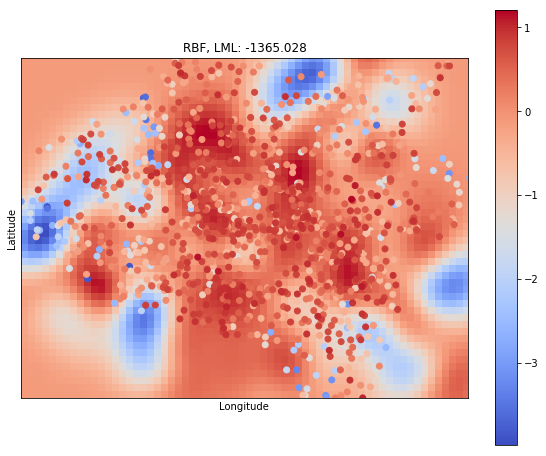

In [11]:
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.figure(figsize=(10,8))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), cmap='coolwarm')
val = plt.scatter(X.iloc[:, 0],X.iloc[:, 1], c=y, cmap='coolwarm' )
plt.colorbar(val)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood(gp.kernel_.theta)))

### Figure 2: Guassian Process Regression Model Prediction versus observed values 

### 4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location?¶

In [12]:
high = y_pred.mean() + 2*y_pred.std()
low = y_pred.mean() - 2*y_pred.std()

In [13]:
per_out = (((y_pred > high).sum() + (y_pred < low).sum())*1.0 / len(y_pred))*100
print('The percentage of data with average traffic counts more than two std \
deviations given the spatial location of the sensors is: ', per_out)

('The percentage of data with average traffic counts more than two std deviations given the spatial location of the sensors is: ', 6.0986547085201792)


### 5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values.¶

In [14]:
y_high = y[y > (y_pred.mean() + 2*y_pred.std())]
y_low = y[y < (y_pred.mean() - 2*y_pred.std())]
y_m = y[(y < high) & (y > low)]

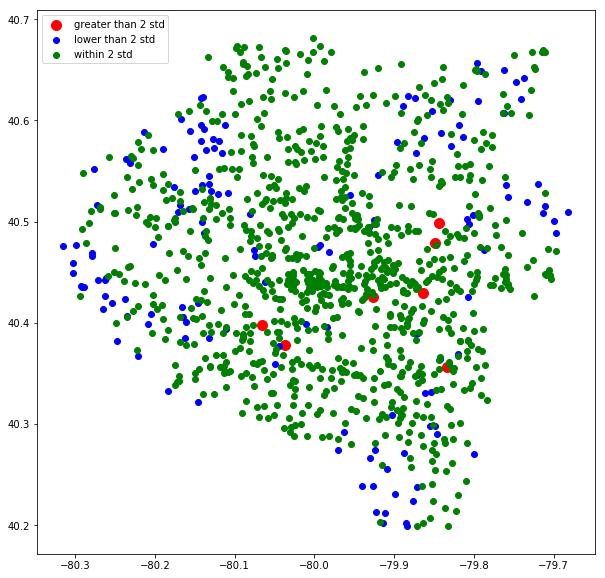

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(X.iloc[y_high.index,0],X.iloc[y_high.index,1], c = 'red', s= 100, label = 'greater than 2 std')
plt.scatter(X.iloc[y_low.index,0],X.iloc[y_low.index,1], c = 'blue', label = 'lower than 2 std')
plt.scatter(X.iloc[y_m.index,0],X.iloc[y_m.index,1], c = 'green', label = 'within 2 std')
plt.legend(loc='best')

### Figure 3: Prediction away from observed values

### Question 2: Cluster-based anomaly detection (10pts, 2.5pts+2.5pts+2.5pts+2.5pts)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 5)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


#### Assign the given values

In [16]:
## Cluster A center co-ordinates 
A_x = 0.0
A_y = 0.0
## Custer B center co-ordinates 
B_x = 35.0
B_y = 5.0
## Cluster C center co-ordinates 
C_x = 15.0
C_y = 20.0 
## Cluster D center co-ordinates 
D_x = 10.0
D_y = 10.0

## Standard deviation of the clusters

## CLuster A std
std1 = 0.1
## CLuster B std
std2 = 5
## CLuster C std
std3 = 1
## CLuster D std
std4 = 1

Cluster A is a dense cluster of 100 points with a std deviation 0.1 while cluster C is a sparse cluster with only 2 points in the cluster. 
### To find the anomaly of the given points two-sigma rule is applied - if the distance of the point from the cluster center is more than two standard deviations then the point is considered anomalous. 
#### Point (1,0) 

In [17]:
x1 = 1.0
y1 = 0.0

dist_a = np.sqrt((A_x - x1)**2 + (A_y - y1)**2)
dist_b = np.sqrt((B_x - x1)**2 + (B_y - y1)**2)
dist_c = np.sqrt((C_x - x1)**2 + (C_y - y1)**2)
dist_d = np.sqrt((D_x - x1)**2 + (D_y - y1)**2)

print("Point (1, 0) distance -")
print("Distance from Cluster A center: {}".format(dist_a))
print("Distance from Cluster B center: {}".format(dist_b))
print("Distance from Cluster C center: {}".format(dist_c))
print("Distance from Cluster D center: {}".format(dist_d))

Point (1, 0) distance -
Distance from Cluster A center: 1.0
Distance from Cluster B center: 34.36568055487916
Distance from Cluster C center: 24.413111231467404
Distance from Cluster D center: 13.45362404707371


The Point (1,0) is anomaly as it doesn't not lie within the two standard deviation area.

The point approximately 10 std deviations away from cluster center A, 6 std deviations away from cluster center B, 24 std deviations away from cluster center C and 13 std deviations away from cluster center D. 

#### Point (35,5)

In [18]:
x2 = 35.0
y2 = 5.0

dist_a = np.sqrt((A_x - x2)**2 + (A_y - y2)**2)
dist_b = np.sqrt((B_x - x2)**2 + (B_y - y2)**2)
dist_c = np.sqrt((C_x - x2)**2 + (C_y - y2)**2)
dist_d = np.sqrt((D_x - x2)**2 + (D_y - y2)**2)

print("Point (35, 5) distance - ")
print("Distance from Cluster A center: {}".format(dist_a))
print("Distance from Cluster B center: {}".format(dist_b))
print("Distance from Cluster C center: {}".format(dist_c))
print("Distance from Cluster D center: {}".format(dist_d))

Point (35, 5) distance - 
Distance from Cluster A center: 35.35533905932738
Distance from Cluster B center: 0.0
Distance from Cluster C center: 25.0
Distance from Cluster D center: 25.495097567963924


Point (35, 5) is not Anomaly as the distance of the point (35,5) from cluster center B is 0.0 which means the point is the cluster center . 


In [19]:
x3 = 15.0
y3 = 19.0

dist_a = np.sqrt((A_x - x3)**2 + (A_y - y3)**2)
dist_b = np.sqrt((B_x - x3)**2 + (B_y - y3)**2)
dist_c = np.sqrt((C_x - x3)**2 + (C_y - y3)**2)
dist_d = np.sqrt((D_x - x3)**2 + (D_y - y3)**2)

print("Point (15, 19) distance -")
print("Distance from Cluster A center: {}".format(dist_a))
print("Distance from Cluster B center: {}".format(dist_b))
print("Distance from Cluster C center: {}".format(dist_c))
print("Distance from Cluster D center: {}".format(dist_d))

Point (15, 19) distance -
Distance from Cluster A center: 24.20743687382041
Distance from Cluster B center: 24.413111231467404
Distance from Cluster C center: 1.0
Distance from Cluster D center: 10.295630140987


Point (15, 19) is not Anomaly 
considering the 2 pts of cluster C, the added point will be part of the cluster and will be at 1 std. dev satisfiyng the two - sigma rule. 

The 3 points including the point (15,19) in cluster C can be considered anomaly as cluster C has only 2 points and other clusters have more than 100 points, thus in comparison to other clusters these three points or the cluster C could be considered anomalous. 

In [20]:
x4 = 10.0
y4 = 11.0

dist_a = np.sqrt((A_x - x4)**2 + (A_y - y4)**2)
dist_b = np.sqrt((B_x - x4)**2 + (B_y - y4)**2)
dist_c = np.sqrt((C_x - x4)**2 + (C_y - y4)**2)
dist_d = np.sqrt((D_x - x4)**2 + (D_y - y4)**2)

print("Point (10, 11) distances - ")
print("Distance from Cluster A center: {}".format(dist_a))
print("Distance from Cluster B center: {}".format(dist_b))
print("Distance from Cluster C center: {}".format(dist_c))
print("Distance from Cluster D center: {}".format(dist_d))

Point (10, 11) distances - 
Distance from Cluster A center: 14.866068747318506
Distance from Cluster B center: 25.709920264364882
Distance from Cluster C center: 10.295630140987
Distance from Cluster D center: 1.0


Point (10, 11) is not Anomaly as it falls within the two sigma area from the cluster center. 


### Question 3: Anomaly detection (5pts+10pts+10pts+10pts+10pts+5pts)

For this question, use the "County Health Indicators dataset" provided to identify the most anomalous counties. Please list the top 5 most anomalous counties by following models: 

Data preprocessing hints: a. convert the strings to float(except the first column). b. drop all nan's. 

(1) Pick up features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'",
             "'Average Daily PM2.5'"] and use pd.cut() to categorize each feature into 5 categories: 0,1,2,3,4. 

a. Use HillClimbSearch and BicScore to learn the baysian network structure. 

b. Which 5 counties have lowest logliklihood values? Please show the counties' name with its loglikelihood values. 

(2) Cluster based anomaly detection.

a.Cluster with k-means. Please set k= 3.Compute each record's distance to the nearest cluster center and report the five counties which have top five highest distances.

b. Cluster with Gaussian Mixture. Please repeat (2)a but use loglikelihood for each record.

(3) Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you choose. 

(4) Compare and contrast the results from different models, and provide some intuitions on why each county was found to be anomalous.  




In [51]:
Data3=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/2016CountyHealthIndicators.csv")
Data3.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [52]:
Data3.iloc[:,1:] = Data3.iloc[:,1:].apply(pd.to_numeric, errors='coerce')
Data3.dropna(inplace=True)

In [53]:
Data3.reset_index(inplace=True, drop=True)

### (1) Pick up features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'", "'Average Daily PM2.5'"] and use pd.cut() to categorize each feature into 5 categories: 0,1,2,3,4.

In [24]:
data3 = Data3.loc[:,["County","'\% Smokers'", "'\% Obese'","'Violent Crime Rate'", \
                     "'80/20 Income Ratio'", 
                  "'\% Children in Poverty'", "'Average Daily PM2.5'"]]

In [25]:
data3.iloc[:,1] = pd.cut(data3.iloc[:,1], 5, labels=[0, 1, 2, 3, 4])
data3.iloc[:,2] = pd.cut(data3.iloc[:,2], 5, labels=[0, 1, 2, 3, 4])
data3.iloc[:,3] = pd.cut(data3.iloc[:,3], 5, labels=[0, 1, 2, 3, 4])
data3.iloc[:,4] = pd.cut(data3.iloc[:,4], 5, labels=[0, 1, 2, 3, 4])
data3.iloc[:,5] = pd.cut(data3.iloc[:,5], 5, labels=[0, 1, 2, 3, 4])
data3.iloc[:,6] = pd.cut(data3.iloc[:,6], 5, labels=[0, 1, 2, 3, 4])

#### a. Use HillClimbSearch and BicScore to learn the baysian network structure.

In [26]:
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
import networkx as nx

In [27]:
hc = HillClimbSearch(data3, scoring_method=BicScore(data3))
best_model = hc.estimate(tabu_length = 200)
print(best_model.edges())

[("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'\\% Children in Poverty'", "'\\% Smokers'"), ("'\\% Smokers'", "'\\% Obese'"), ("'\\% Smokers'", "'Average Daily PM2.5'"), ("'Violent Crime Rate'", "'\\% Children in Poverty'")]


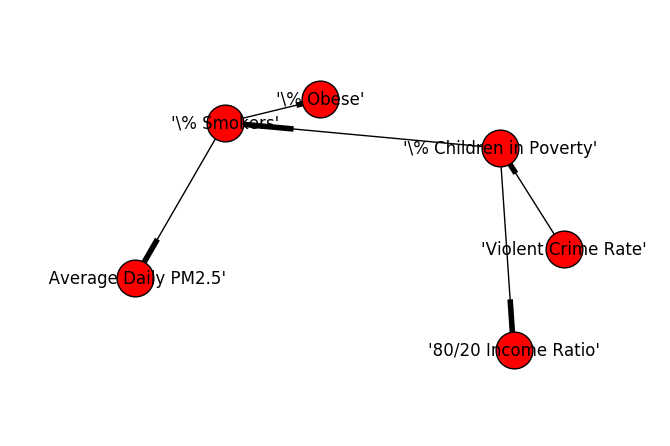

In [28]:
G = nx.DiGraph()
G.add_edges_from(best_model.edges())
# pos = {'H':(25,75), 'A':(25,50), 'G':(50,50), 'D':(0,25), 'C':(25,0), 'B':(50, 25)}
nx.draw(G, with_labels=True, arrows=True, node_size=700)

### Figure 4: Network of Bayesian model.

In [29]:
model = BayesianModel(best_model.edges())

# Learing CPDs using Maximum Likelihood Estimators
model.fit(data3, estimator=MaximumLikelihoodEstimator)

In [30]:
infer = VariableElimination(model)

In [31]:
def logLiklihood(x,infer):
    a=x["'\% Smokers'"]
    b=x["'\% Obese'"]
    c=x["'Violent Crime Rate'"]
    d=x["'80/20 Income Ratio'"]
    e=x["'\% Children in Poverty'"]
    f=x["'Average Daily PM2.5'"]
    
    return (np.log((infer.query(["'\% Children in Poverty'"],
            evidence={"'Violent Crime Rate'": c})["'\% Children in Poverty'"]).values[e])
         + np.log((infer.query(["'80/20 Income Ratio'"],
            evidence={"'\% Children in Poverty'": e})["'80/20 Income Ratio'"]).values[d])
         + np.log((infer.query(["'\% Smokers'"], 
            evidence={"'\% Children in Poverty'": e})["'\% Smokers'"]).values[a])
         + np.log((infer.query(["'\% Obese'"], 
            evidence={"'\% Smokers'": a})["'\% Obese'"]).values[b])
         + np.log((infer.query(["'Average Daily PM2.5'"], 
            evidence={"'\% Smokers'": a})["'Average Daily PM2.5'"]).values[f]))

In [32]:
anomaly = data3.iloc[:,1:].apply(lambda x: logLiklihood(x,infer),axis=1)

In [33]:
## Top 5 anomalies 
top = anomaly.sort_values()[:5]

In [34]:
bn_ano = pd.concat((Data3.iloc[:,0],anomaly), axis=1).sort_values(0)[:5]
bn_ano.columns = ['County','loglikelihood']
bn_ano

,County,loglikelihood
1444,"New York, New York",-14.968008
1577,"Rolette, North Dakota",-14.436174
182,"San Francisco, California",-13.186663
1313,"Silver Bow, Montana",-13.169896
1728,"Benton, Oregon",-13.160786


### (2) Cluster based anomaly detection.

#### a.Cluster with k-means. Please set k= 3.Compute each record's distance to the nearest cluster center and report the five counties which have top five highest distances.
#### b. Cluster with Gaussian Mixture. Please repeat (2)a but use loglikelihood for each record.

In [35]:
X = Data3.iloc[:,1:]

### KMeans Clustering 

In [36]:
from sklearn.cluster import KMeans
n=3
KM=KMeans(n_clusters=n,random_state=9991)
scor=KM.fit(X)

In [37]:
res=pd.DataFrame(KM.transform(X))

In [38]:
res=pd.concat((Data3.iloc[:,0],res.min(1)),axis=1)

In [39]:
kmeans_ano = res.sort_values(0,ascending=False)[:5]
kmeans_ano.columns = ['County','distance']
kmeans_ano

,County,distance
1890,"Shannon, South Dakota",1970.324198
1294,"St. Louis City, Missouri",1333.684659
96,"Crittenden, Arkansas",1209.851405
2304,"Petersburg City, Virginia",1018.437370
995,"Baltimore City, Maryland",919.349842


### Guassian Mixture Model

In [40]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [41]:
gm_ano = pd.concat((Data3.iloc[:,0],pd.Series(GM.score_samples(X))), axis=1).sort_values(0)[:5]
gm_ano.columns = ['County', ' loglikelihood']
gm_ano

,County,loglikelihood
1890,"Shannon, South Dakota",-197.420106
66,"Apache, Arizona",-133.042814
1444,"New York, New York",-131.452092
2158,"Willacy, Texas",-129.450559
1577,"Rolette, North Dakota",-126.696033


### 3) Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you choose.

In [42]:
from sklearn.ensemble import IsolationForest

In [43]:
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(X)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples=100, n_estimators=100, n_jobs=1, random_state=999,
        verbose=0)

In [44]:
isof_ano = pd.concat((Data3.iloc[:,0],pd.Series(clf.decision_function(X))),axis=1).sort_values(0)[:5]
isof_ano.columns = ['County', 'Avg_anomaly_score']
isof_ano

,County,Avg_anomaly_score
1890,"Shannon, South Dakota",-0.136942
66,"Apache, Arizona",-0.090887
127,"Phillips, Arkansas",-0.089880
913,"East Carroll, Louisiana",-0.077793
1577,"Rolette, North Dakota",-0.077301


### (4) Compare and contrast the results from different models, and provide some intuitions on why each county was found to be anomalous.

The commmon counties from the models are:

* Shannon, South Dakota

* New York, New York

* Rolette, North Dakota

All these counties are anomlies by atleast 2 of more of the models used. 

In [54]:
Data3.set_index('County', inplace=True)

In [64]:
ana_county = Data3[(Data3.index == 'Shannon, South Dakota') |
      (Data3.index == 'Rolette, North Dakota') |
      (Data3.index == 'New York, New York')
      ].loc[:,["'\% Smokers'", "'\% Obese'","'Violent Crime Rate'", "'80/20 Income Ratio'", 
                  "'\% Children in Poverty'", "'Average Daily PM2.5'"]]

In [65]:
ana_county

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"New York, New York",13.0,15,620.0,8.7,24.0,10.8
"Rolette, North Dakota",38.0,41,29.0,7.7,41.0,9.6
"Shannon, South Dakota",41.0,45,0.0,6.5,54.0,11.8


It can be observed that the three common anomalies have high percentage of smokers, obesity, violent crime rate , poverty in children and 80/20 Income ratio ( all the features selected for bayesian model) 

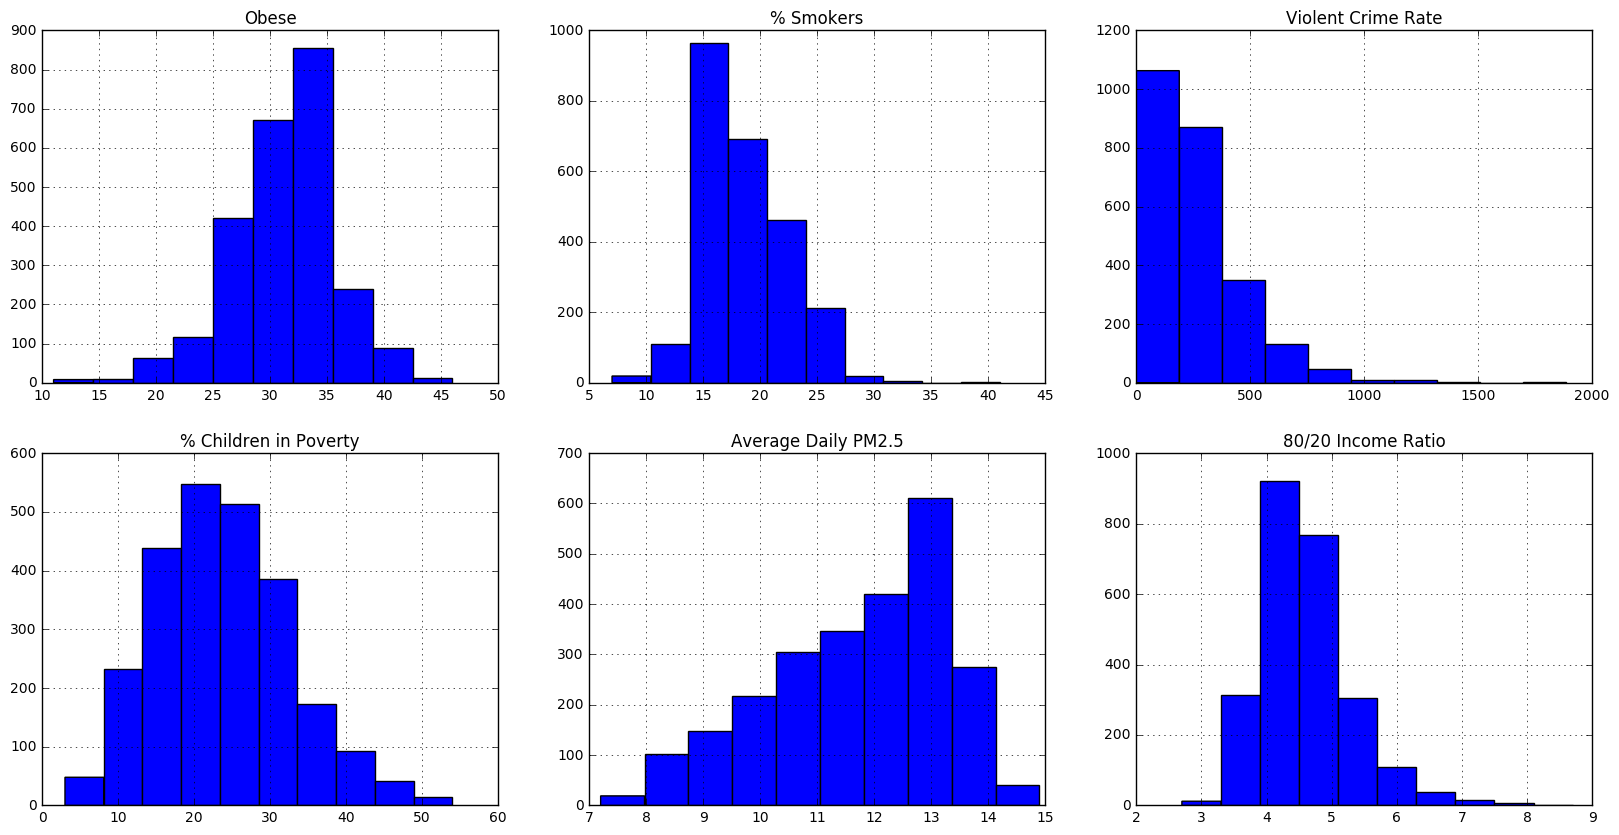

In [67]:
## plot the selected features

fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(231)
Data3["'\% Obese'"].hist(ax = ax1)
plt.title('Obese')

ax2 = plt.subplot(232)
Data3["'\% Smokers'"].hist(ax = ax2)
plt.title('% Smokers')

ax3 = plt.subplot(233)
Data3["'Violent Crime Rate'"].hist(ax = ax3)
plt.title('Violent Crime Rate')

ax4= plt.subplot(234)
Data3["'\% Children in Poverty'"].hist(ax = ax4)
plt.title('% Children in Poverty')

ax5= plt.subplot(235)
Data3["'Average Daily PM2.5'"].hist(ax = ax5)
plt.title('Average Daily PM2.5')

ax6= plt.subplot(236)
Data3["'80/20 Income Ratio'"].hist(ax = ax6)
plt.title('80/20 Income Ratio')


There are four different models used for detecting the anomaly in County Health Indicators. 

It can be seen that the KMeans clustering method gives the **robust clusters** while the guassian mixture model gives a **soft assignment** of clusters. In KMeans clustering the anomaly detection is based on the distance from the cluster centers while in Guassian Mixture models it is based on loglikehood ratio of the points. 

Also it can be observed that Bayesian model developed on the bayesian network also detect anomalies based on loglikehood.  The results thus seen are similar with two counties (New York and Rolette, North Dakota) same in both the processes as both these models have an underlying assumption of causality in the model giving similar results. 

Isolation forest is generally used for Novelty detection. It is used here for outlier detection and it performs well. 